## Root model of auxin distribution - 1 dimension

### Model structure
The overall model implements a line of cells, usually including a QC at an arbitrary position, and determines the transport and diffision of the auxin concentration across the line of cells over time.

$$Aux_{i}^{t+1}=Aux_{i}^{t}+PINtransport_{i,IN}^{t}+PINtransport_{i,OUT}^{t}+diffusion_{i,IN}^{t}+diffusion_{i,OUT}^{t} + \delta_{i,QC}*Source + decay*Aux_{i}^{t}$$ (1)

$PINtransport_{i,IN}^{t}$: PIN-mediated transport from neighbouring cells to the $i$-th cell.

$$PINtransport_{i,IN}^{t} = T * \sum_{k \in Neigh(i)}{P_{k,OUT} * Aux_{k}^{t}}$$

$PINtransport_{i,OUT}^{t}$: PIN-mediated transport from the i-th cell to the neighbouring cells.

$$PINtransport_{i,OUT}^{t} = - T * Aux_{i}^{t} * \sum_{k \in Neigh(i)}{P_{k,OUT}}$$

$diffusion_{i,IN}^{t}$: Background influx of auxin permeating thorugh cell membranes.

$$diffusion_{i,IN}^{t} = D * \sum_{k \in Neigh(i)}{Aux_{k}^{t}}$$

$diffusion_{i,OUT}^{t}$: Background influx of auxin permeating thorugh cell membranes.

$$diffusion_{i,OUT}^{t} = - D * \sum_{k \in Neigh(i)}{Aux_{k}^{t}}$$

$\delta_{i,QC}$: Delta function that returns $1$ when the index $i$ of the cell equals the index of the QC cell. This piece was introduced to include in the model a constant of source of auxin bearing exclusively from the QC cell.

$decay*Aux_{i}^{t}$: Constant rate of decay of auxin through time.

| Symbol      | Description                                                                                                                                            |
|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|
| $Aux$       | Auxin concentration (in arbitrary units)                                                                                                               |
| $i$         | i-th cell                                                                                                                                              |
| $t$         | t-th timestep                                                                                                                                          |
| $T$         | Coefficient of transport of auxin (think of the proportion of auxin available for transport by PIN proteins)                                           |
| $D$         | Coefficient of diffusion of auxin (summarizes the ability of auxin to permeate through membranes and cell walls)                                       |
| $Neigh(i)$  | Neighbouring cells of $i$. In a 1-D model, they represent the cell on the left and on the right (or up and down if the model is conceived as vertical) |
| $k$         | index indicating the k-th element of the set of Neigh(i), the neighbouring cells of $i$                                                                |
| $P_{k,OUT}$ | Proportion of PIN proteins available for transport of auxin *outside* of the cell $k$ into the the cell $i$                                            |
| $P_{k,IN}$  | Proportion of PIN proteins available for transport of auxin *inside* cell $i$ from cell $k$                                                            |
| $Source$    | Amount of auxin generated at each timestep (constant value)                                                                                            |
<hr>

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook 

Here declared the simulation time ```sim_time``` (in arbitrary time units) and the time step ```time_step```

In [114]:
# simulation time
sim_time = 36
time_step = 0.5

$P_{IN}$ and $P_{OUT}$ are represented for ease of computation as matrices of size (#cells, 2). The number 2 is given by the fact that, being in a 1-D model, we only have two neighbours (one on the left and one the right, or one up and one down if we draw the line of cells vertically).

In the **Standard central lane of cells** model the PIN proteins upwards with respect to the QC exert a PIN-mediated transport **exclusively** downwards (thus towards the QC cell).

The QC cell is at index 3 in this example.

In [195]:
# STANDARD CENTRAL LANE OF CELLS (<-> QC <-------)

QC = 3
P_in = np.ones((32,2))
#QC cells don't have intake of PIN proteins (?)
P_in[QC,:] = [1,1]
# opposite direction in the bottom cells
P_in[0:QC,:] = [1,1]
P_in[QC+1:, 0] = 0.2
P_in[QC+1:, 1] = 0.8

P_out = np.zeros((32,2))
P_out[QC,:] = [1,1]
# opposite direction in the bottom cells
P_out[0:QC,:] = [1,1]
P_out[QC+1:, 0] = 0.8
P_out[QC+1:, 1] = 0.2

In [133]:
# FAKE LANE OF CELLS (<-- QC ------->)

# to be fixed
#######################################
P_in[QC,:] = [0,0]
# opposite direction in the bottom cells
P_in[0:QC,:] = [0,1]
P_in[QC+1:, 0] = 0.2
P_in[QC+1:, 1] = 0.8

P_out = np.zeros((32,2))
P_out[QC,:] = [1,1]
# opposite direction in the bottom cells
P_out[0:QC,:] = [1,0]
P_out[QC+1:, 0] = 0
P_out[QC+1:, 1] = 1

### The update function

This function is the core of the simulation model.
The algorithm is described in these steps here reported:

```
-1) an helper element gets declared to extract neighbouring cells from the input

1) an empty vector is declared to store the t+1 update (updated_cells)

FOR

2) for loop extracting the index and value (auxin conncentration) of each cell, starting from the bottom

3) extract neighbours' auxin concentrations

4) calculating the amount of auxin entering the cell from background influx at time t+1

5) calculating the amount of auxin escaping the cell from background efflux at time t+1

6) calculating the amount of auxin that decays at time t+1

7) control flow to check if the cell i has only one neighbour (like in the extremities)

7.1.1) calculating the amount of auxin entering the cell by PIN-mediated transport at time t+1

7.1.2) calculating the amount of auxin escaping the cell by PIN-mediated transport at time t+1

7.2.1) calculating the amount of auxin entering the cell by PIN-mediated transport at time t+1

7.2.2) calculating the amount of auxin escaping the cell by PIN-mediated transport at time t+1

8) summing all the values calculated previously to the value of auxin at time t

9) control flow to check if the amount calculated results as negative

9.1) setting the set value to 0

10) assigning the step value to the empty vector storing values to return

END FOR

11) RETURN the vector with the updated concentrations of auxin for time step t+1
```

In [202]:
def update(cells, source=QC, source_val=200, D=0.4, T=0, P_in=P_in, P_out=P_out, decay=0.0005):
    """
    updates vector of cells following equation (1)
    
    WORKS ONLY FOR 1D MODELS
    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_in : numpy matrix (n_cells,2), amount of PIN1 that a cell intakes from every neighbour (from the front or the back)
    P_out : numpy matrix (n_cells,2), amount of PIN1 that a cell outtakes to every neighbour (to the front or the back)
    """
    # define neighbours
    v = np.array([-1,0], [1,0], [0,-1], [0,1])
    updated_cells = np.zeros((len(cells),1))
    for index, value in enumerate(cells):
        # extract neighbours from all cells
        neighbours = cells[list(filter(lambda x: x >= 0 and x < len(cells), v + index))]
        diffusion_in = D*(sum(neighbours))
        diffusion_out = -D*value*len(neighbours)
        aux_decay = -decay*value
        # if it's at the ends
        if neighbours.shape[0] == 1:
            transport_in = T*sum(P_out[index,:])*neighbours
            transport_out = -T*sum(P_out[index,:])*value
        else:
            transport_in = T*np.dot(P_out[index,:],neighbours)
            transport_out = -T*sum(P_out[index,:])*value
        step = value + transport_in + transport_out + diffusion_in + diffusion_out + aux_decay
        # we update only if the concentration is increased, add 0 otherwise
        if step < 0:
            step = 0
        # adding source
        updated_cells[index,0] = step
    updated_cells[source] += source_val
    return updated_cells

### Simulation execution

For each iteration an horizontal model of the root is drawn. The color maps the varying concentration of auxin within the cells. The root is oriented from root tip up to the top differentiated zone.

```cells_a``` is the vector of cells initialized with an arbitrary value of 20 for all cells.

```cells_out``` is the output vector of cells after ```sim_time``` time.

<IPython.core.display.Javascript object>


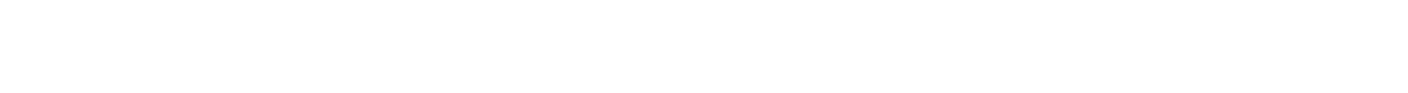

<IPython.core.display.Javascript object>


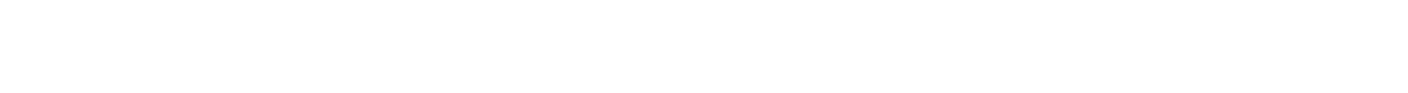

In [203]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((32,1))*20

fig= plt.figure(figsize=(15,1)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a.T, cmap="jet")
cells_out = cells_a
for t in np.arange(0, sim_time, time_step):
    cells_out = update(cells_out, source_val=20, D=0.4, T=0.01, decay=0.05)
    plt.imshow(cells_out.T, cmap="jet")
    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()

<BarContainer object of 32 artists>

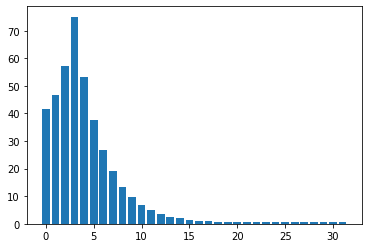

In [204]:
%matplotlib inline
plt.bar(x=list(range(len(cells_out))),height=cells_out[:,0])

/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


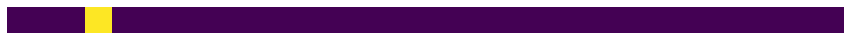

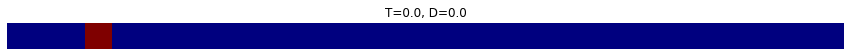

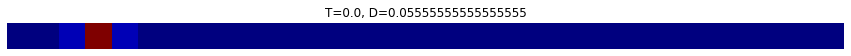

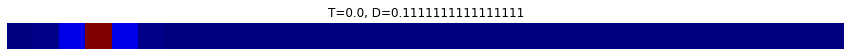

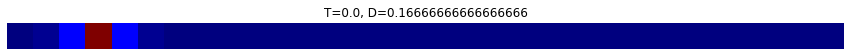

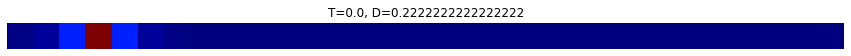

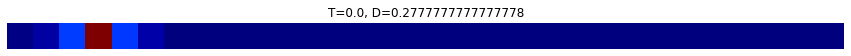

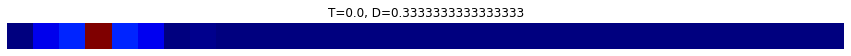

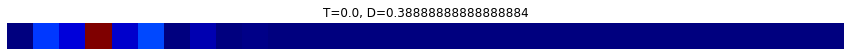

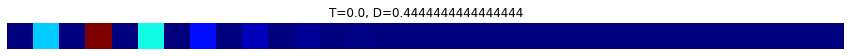

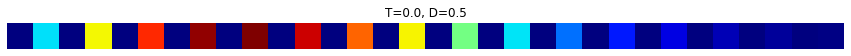

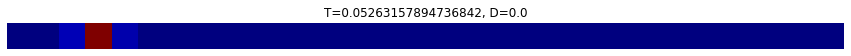

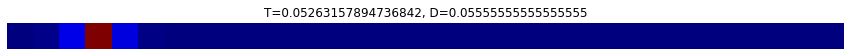

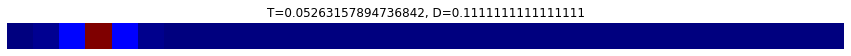

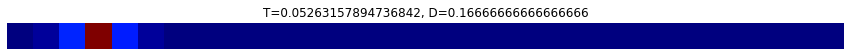

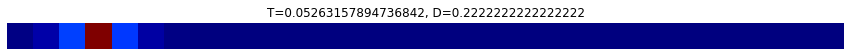

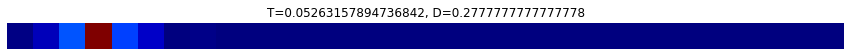

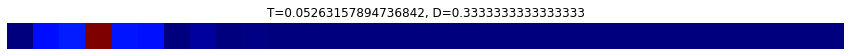

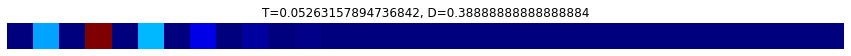

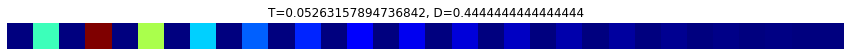

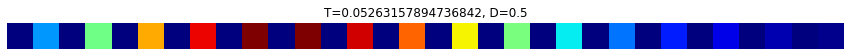

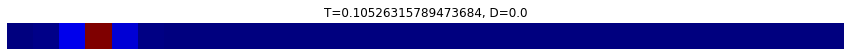

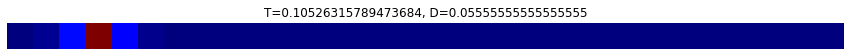

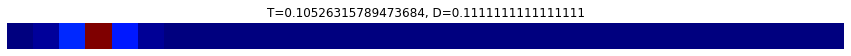

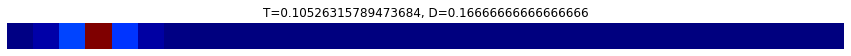

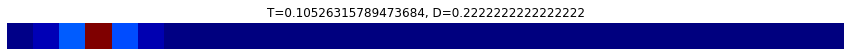

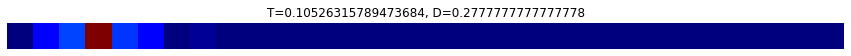

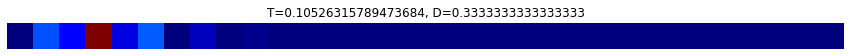

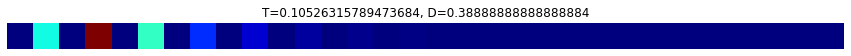

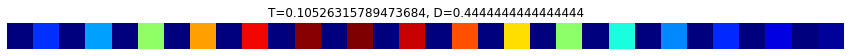

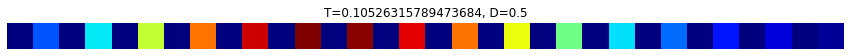

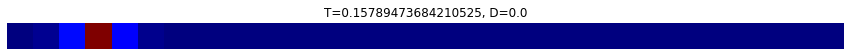

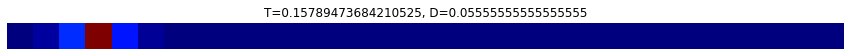

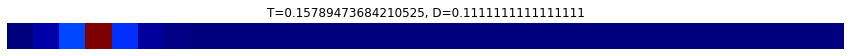

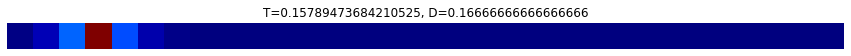

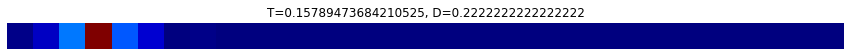

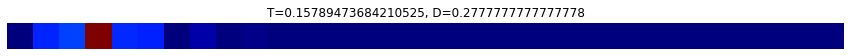

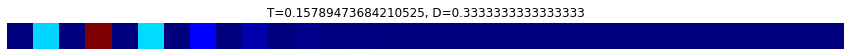

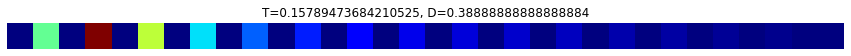

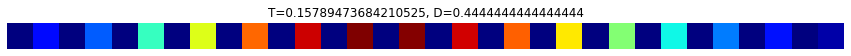

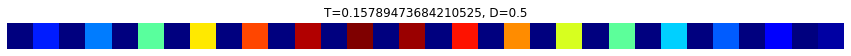

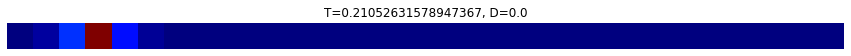

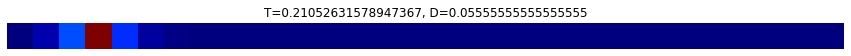

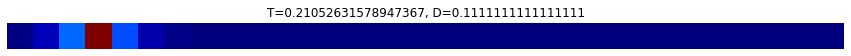

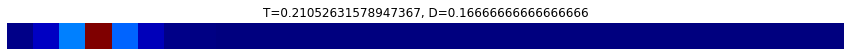

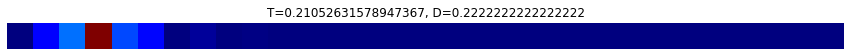

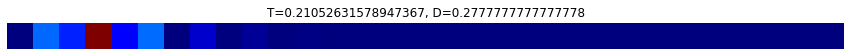

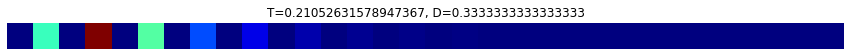

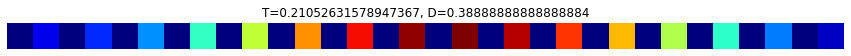

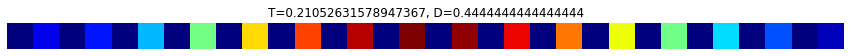

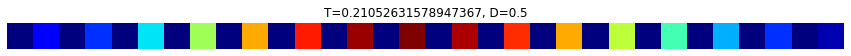

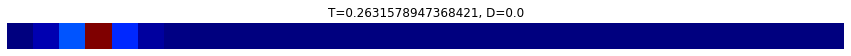

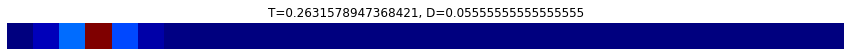

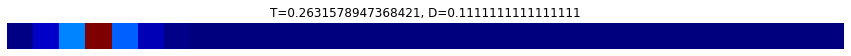

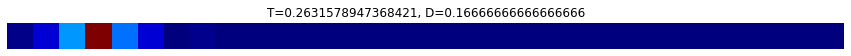

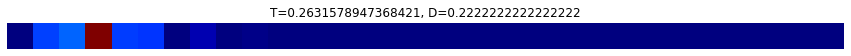

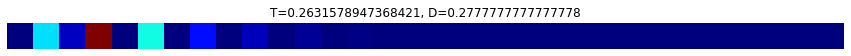

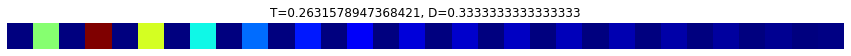

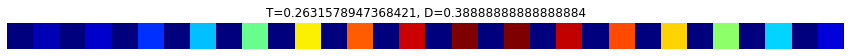

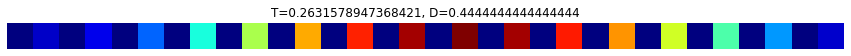

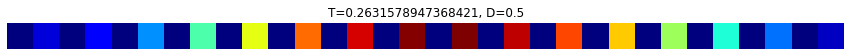

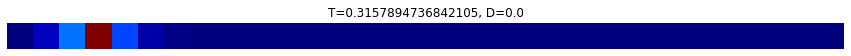

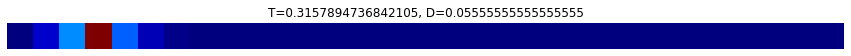

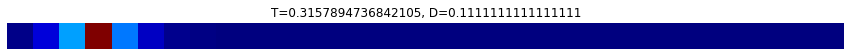

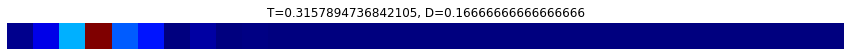

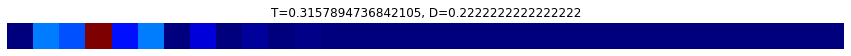

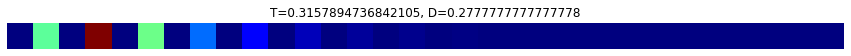

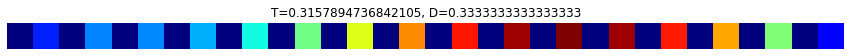

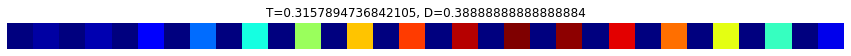

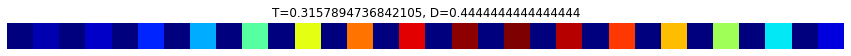

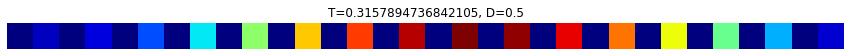

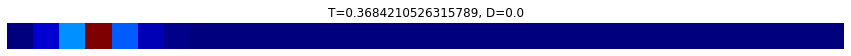

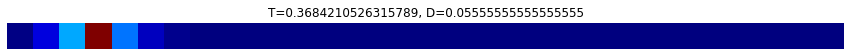

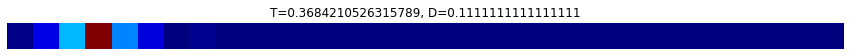

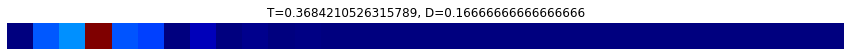

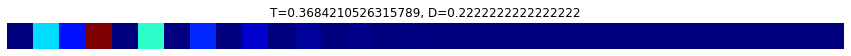

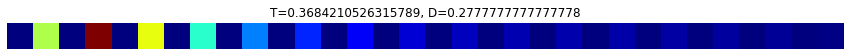

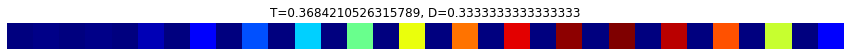

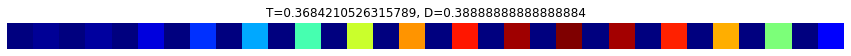

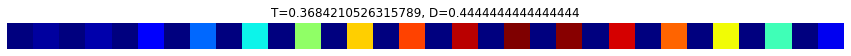

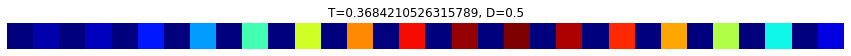

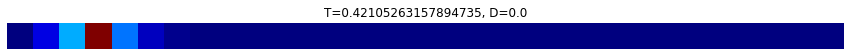

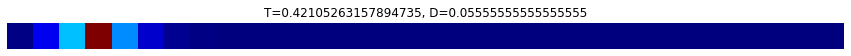

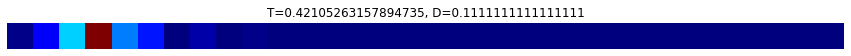

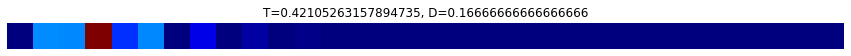

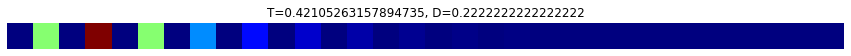

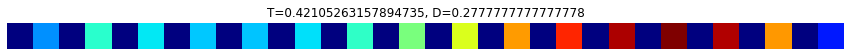

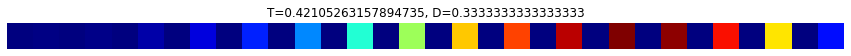

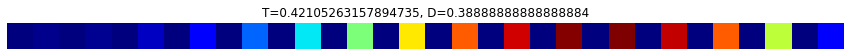

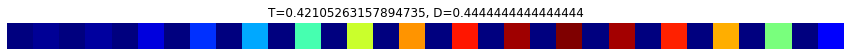

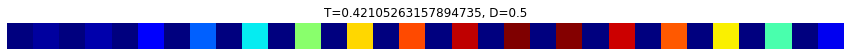

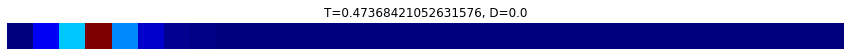

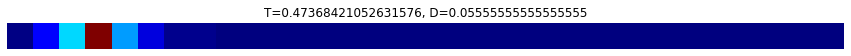

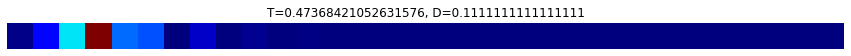

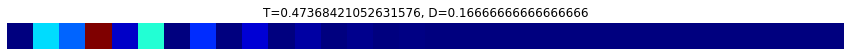

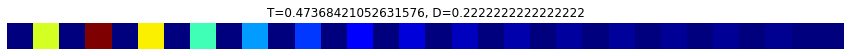

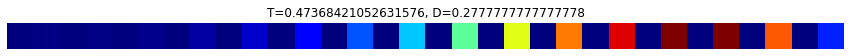

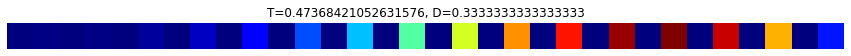

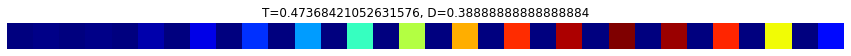

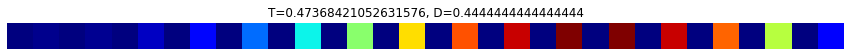

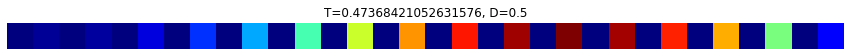

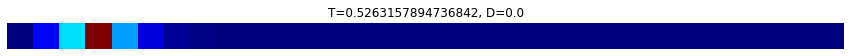

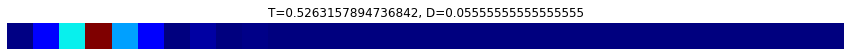

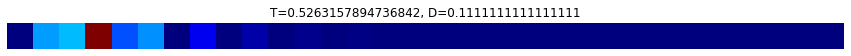

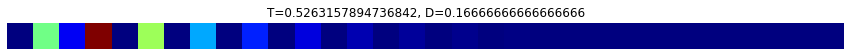

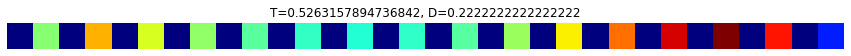

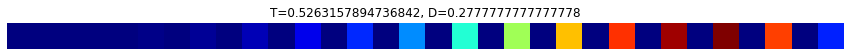

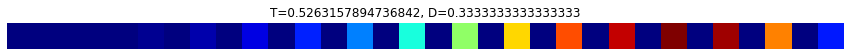

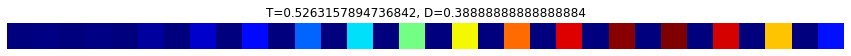

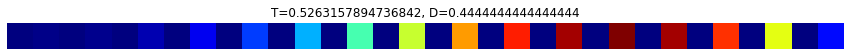

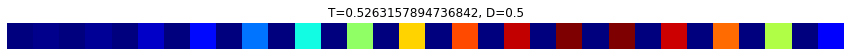

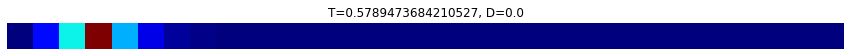

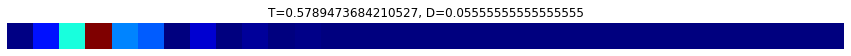

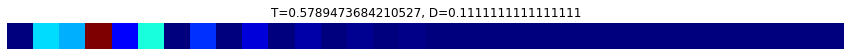

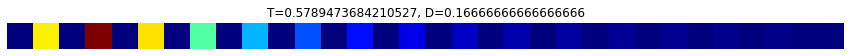

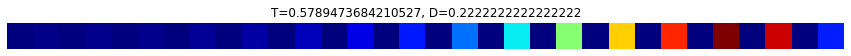

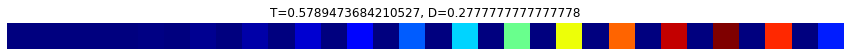

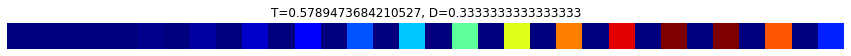

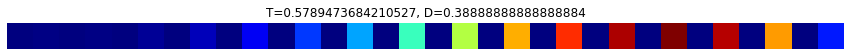

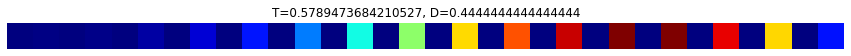

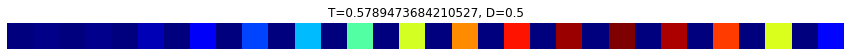

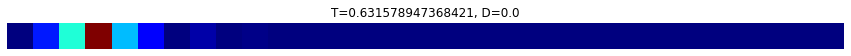

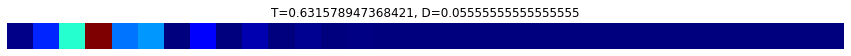

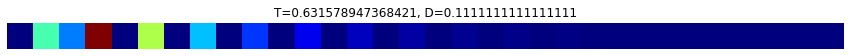

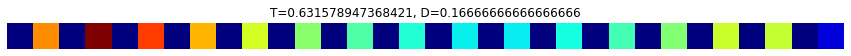

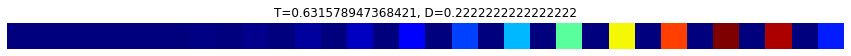

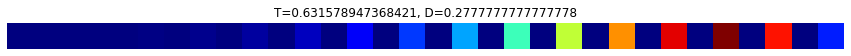

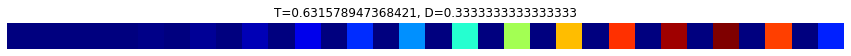

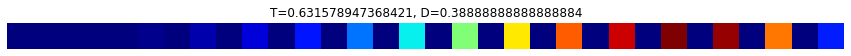

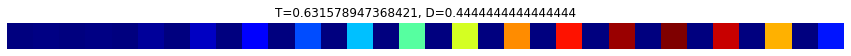

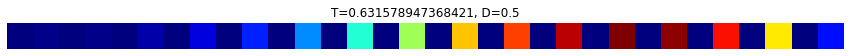

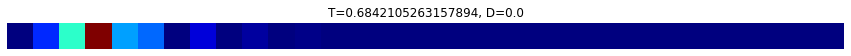

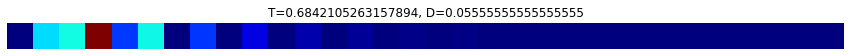

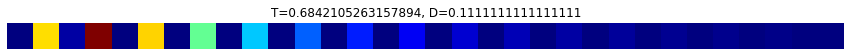

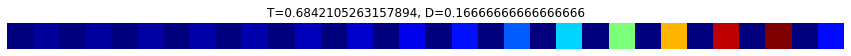

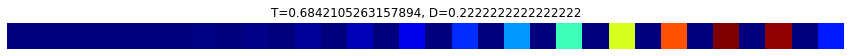

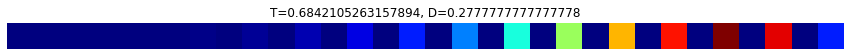

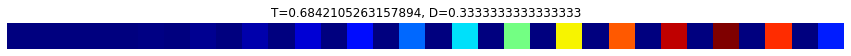

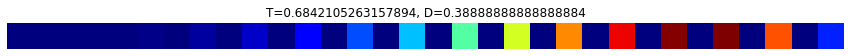

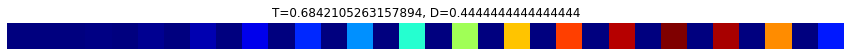

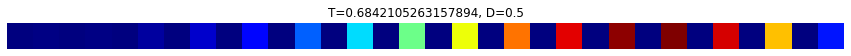

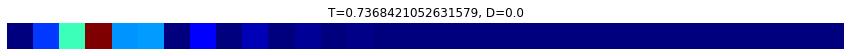

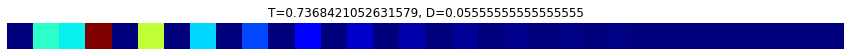

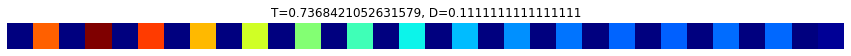

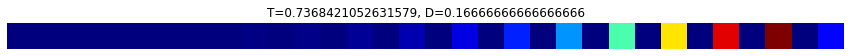

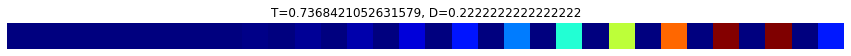

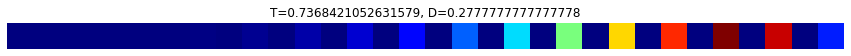

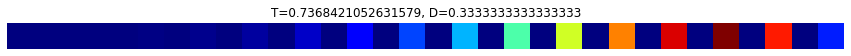

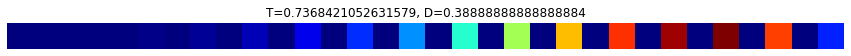

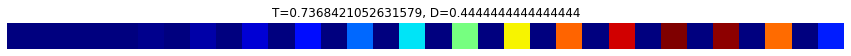

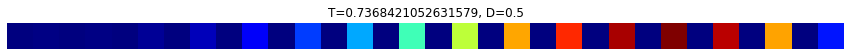

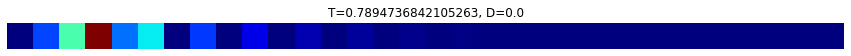

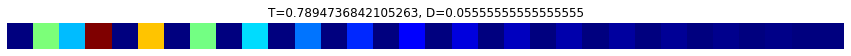

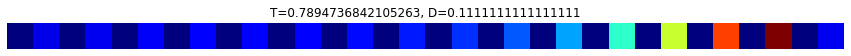

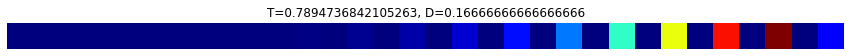

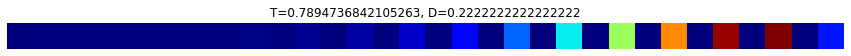

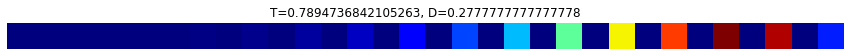

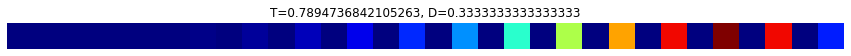

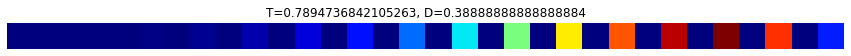

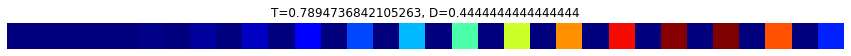

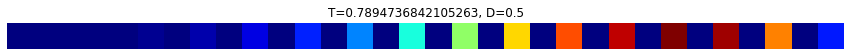

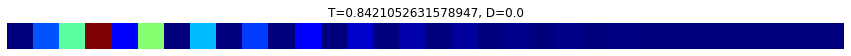

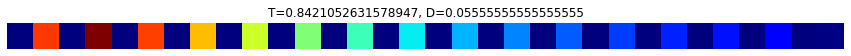

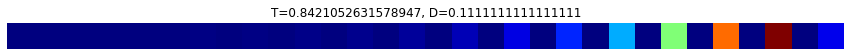

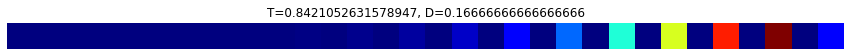

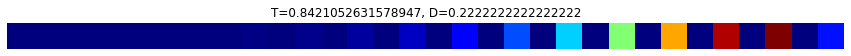

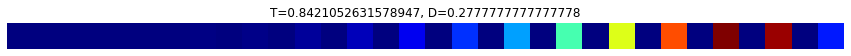

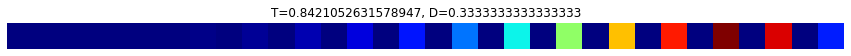

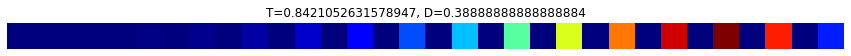

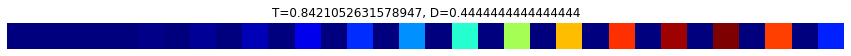

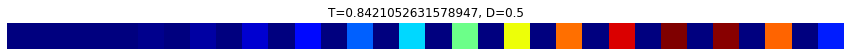

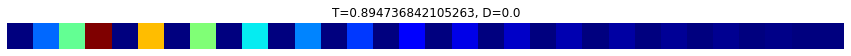

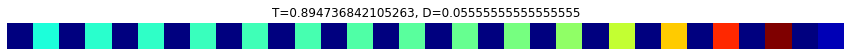

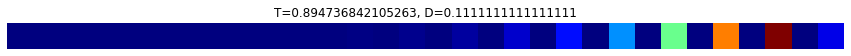

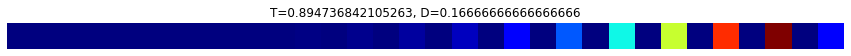

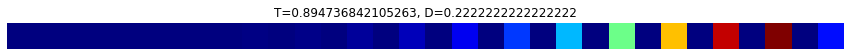

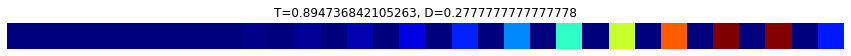

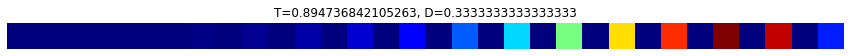

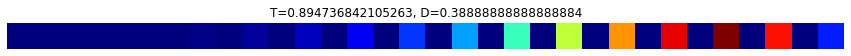

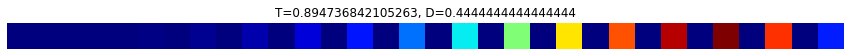

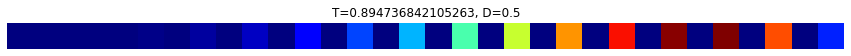

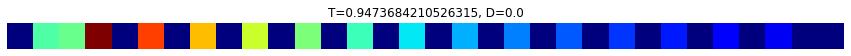

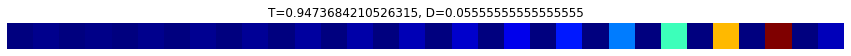

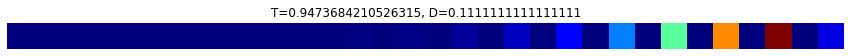

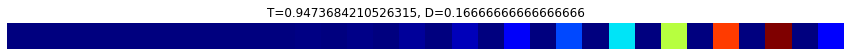

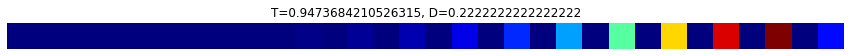

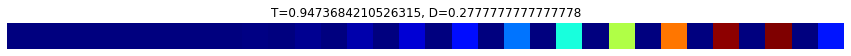

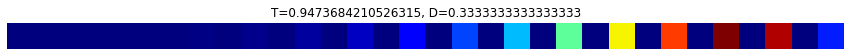

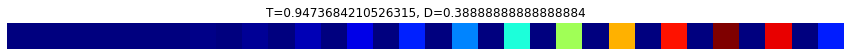

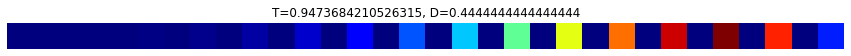

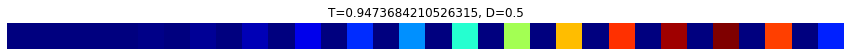

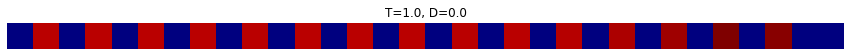

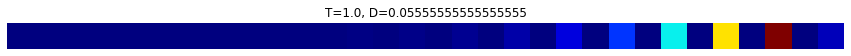

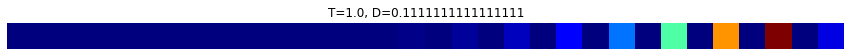

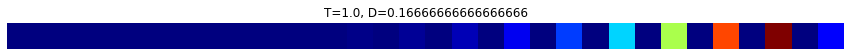

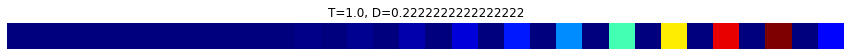

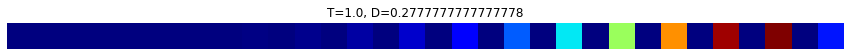

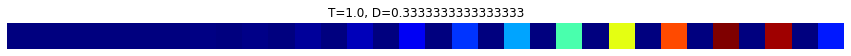

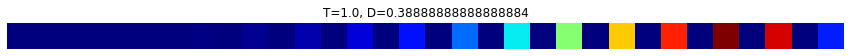

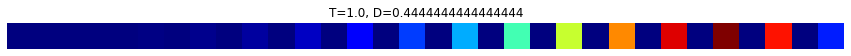

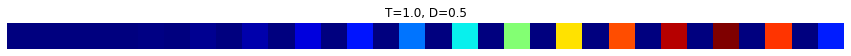

In [506]:
# BENCHMARKING
plt.figure(figsize=(15,1))
plt.axis('off')
plt.imshow(cells.T)

Ts = np.linspace(0,0.5,20)
Ds = np.linspace(0,0.5,10)

cells_arrays = [cells]
for T,D in np.array(np.meshgrid(Ts,Ds)).T.reshape(-1,2):
    # initialize to the initial state
    cells_out = cells_arrays[0]
    # iterate until convergence
    for t in np.arange(0, sim_time, time_step):
        cells_out = update(cells_out, D=D, T=T)
    # plot converged root
    plt.figure(figsize=(15,1))
    plt.imshow(cells_out.T, cmap="jet")
    plt.title(f"T={T}, D={D}")
    plt.axis('off')
    plt.draw()